# Convert Tactus xml files to csv files

In [1]:
import gzip
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import xml.etree.ElementTree as ET
from nltk import word_tokenize

In [2]:
CLIENT = "client"
COUNSELOR = "counselor"
DATADIR = "../usb/tmp/20190917/"
FILEPATTERN = "AdB.*xml.gz"
OUTDIR = "../usb/releases/20201018/"

In [3]:
TACTUSMAIL = "alcoholdebaas@tactus.nl"
EMAIL = "Email"

def dictToString(data):
    string = ""
    for key in sorted(data.keys()):
        string += key+":"+data[key]+" "
    return(string)

def inExcludedCounselors(counselorString):
    return(not re.search(EMAIL+":",counselorString,flags=re.IGNORECASE) or \
           re.search(TACTUSMAIL,counselorString,flags=re.IGNORECASE))

def fileNameToId(fileName):
    return(fileName.split(".")[0].split("-")[0])

def readGzippedXmlFile(inFileName):
    inFile = gzip.open(inFileName)
    inFileContent = inFile.read()
    inFile.close()
    root = ET.fromstring(inFileContent)
    return(root)

def cleanupText(text):
    return(re.sub("\n",r" \\n ",text.strip()))

In [4]:
def showValueFrequencies(answerDataDf):
    x = sorted(set(answerDataDf[CLIENT]))
    answerDataDfGroups = answerDataDf.groupby([CLIENT])
    y = [len(answerDataDfGroups.groups[client]) for client in x]
    yCounts = {yValue:y.count(yValue) for yValue in y}
    yCountsSorted = {yValue:yCounts[yValue] for yValue in sorted(yCounts.keys(),key=lambda yValue:yCounts[yValue],reverse=True)}
    return(yCountsSorted)

## Process tag AssignedCounselor (counselors.csv)

In [5]:
COUNSELORQUERY = "./AssignedCounselor"
OUTFILENAME = "counselors.csv.gz"

def getCounselorData():
    inFileNames = sorted(os.listdir(DATADIR))
    clientList = []
    counselorDict = {"":0}
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIR+inFileName)
            for counselor in root.findall(COUNSELORQUERY):
                counselorData = {}
                for i in range(0,len(counselor)):
                    try:
                        counselorData[counselor[i].tag.strip()] = counselor[i].text.strip()
                    except: pass
            counselorString = dictToString(counselorData)
            if not counselorString in counselorDict:
                counselorDict[counselorString] = len(counselorDict)
            clientList.append((fileNameToId(inFileName),counselorDict[counselorString]))
    return(clientList,counselorDict)

In [6]:
PLOTFILENAME = "AssignedCounselor.png"

def clientDictToCounselorDf(clientDict):
    counselorDf = pd.DataFrame(clientDict,index=[0]).T.rename(columns={0:COUNSELOR})
    counselorDf.index.name = CLIENT
    return(counselorDf)

def saveCounselorDf(counselorDf,outFileName=OUTFILENAME):
    counselorDf.to_csv(OUTDIR+outFileName)
    
def visualizeCounselorDf(counselorDf,counselorDict):
    counselorGroups = counselorDf.groupby(COUNSELOR).groups
    counselorDictT = {counselorDict[c]:c for c in counselorDict}
    x = [c for c in sorted(counselorGroups.keys()) if not inExcludedCounselors(counselorDictT[c])]
    y = [len(counselorGroups[g]) for g in x]
    plt.figure(figsize=(10,5))
    matplotlib.rc("font",**{"size":12})
    plt.bar(x,y)
    plt.xlabel("counselor id")
    plt.title(f"Number of clients per counselor (average: {round(np.average(y),1)}; standard deviation: {round(np.std(y))})")
    plt.savefig(PLOTFILENAME)
    plt.show()
    
def showExcludedCounselors(counselorDf,counselorDict):
    counselorGroups = counselorDf.groupby(COUNSELOR).groups
    for c in counselorDict:
        if inExcludedCounselors(c):
            print(f"id: {counselorDict[c]}; frequency: {len(counselorGroups[counselorDict[c]])}; data: {c}")
    

In [7]:
clientList,counselorDict = getCounselorData()
clientDict = {key:value for (key,value) in clientList}
counselorDf = clientDictToCounselorDf(clientDict)
saveCounselorDf(counselorDf,outFileName=OUTFILENAME)
print(f"number of client-counselor pairs: total: {len(clientList)}; one per client: {len(clientDict.keys())}")

number of client-counselor pairs: total: 1983; one per client: 1983


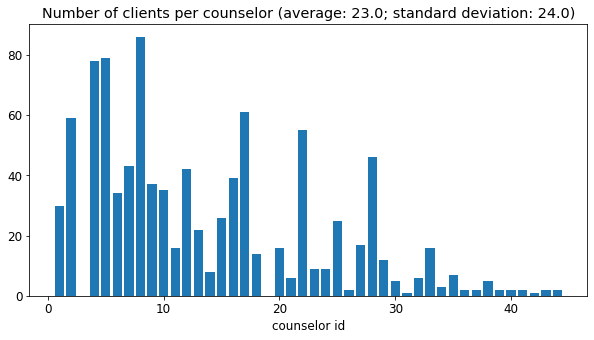

In [8]:
visualizeCounselorDf(counselorDf,counselorDict)

In [9]:
showExcludedCounselors(counselorDf,counselorDict)

id: 0; frequency: 763; data: 
id: 3; frequency: 254; data: Email:alcoholdebaas@tactus.nl FirstName:Geen LastName:Hulpverlener 
id: 19; frequency: 1; data: Email:alcoholdebaas@tactus.nl FirstName:Aangehouden LastName:cliënten 
id: 45; frequency: 1; data: Email:alcoholdebaas@tactus.nl FirstName:Niet LastName:Gestart 


## Process tag Intake (clients.csv)

In [5]:
TITLE = "title"
TITLECAPS = "Title"
QUESTIONNUMBER = "questionNumber"
ANSWER = "answer"
ANSWERID = "answerId"
ANSWERTEXT = "answerText"
ANSWERTITLE = "answerTitle"
ID = "ID"
INTAKE = "Intake"
QUERYINTAKE = "./Intake"
QUERYQUESTION = ".//question"
QUERYTITLE = "./"+TITLE
QUERYQUESTIONNUMBER = "./"+QUESTIONNUMBER
QUERYANSWER = "./"+ANSWER
QUERYANSWERTEXT = "./"+ANSWERTEXT
OUTFILENAME = "clients.csv.gz"
PLOTFILENAME = "Intake.png"
TITLESTRING = "Number of questions per client in Intake forms"
TREATMENTTITLE = "treatmentTitle"

In [6]:
def getAnswerDataList(querySection=QUERYINTAKE):
    inFileNames = sorted(os.listdir(DATADIR))
    answerDataList = []
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIR+inFileName)
            for section in root.findall(querySection):
                for question in section.findall(QUERYQUESTION):
                    answerDict = {CLIENT:fileNameToId(inFileName),TREATMENTTITLE:INTAKE}
                    try:
                        answerDict[TITLE] = list(question.findall(QUERYTITLE))[0].text.strip()
                    except: pass
                    try:
                        answerDict[QUESTIONNUMBER] = list(question.findall(QUERYQUESTIONNUMBER))[0].text.strip()
                    except: pass
                    for answer in question.findall(QUERYANSWER):
                        answerDictCopy = dict(answerDict)
                        answerDictCopy[ANSWERID] = answer.attrib[ID]
                        try:
                            answerDictCopy[ANSWERTEXT] = list(answer.findall(QUERYANSWERTEXT))[0].text.strip()
                        except: pass
                        try:
                            answerDictCopy[ANSWERTITLE] = list(answer.findall(QUERYTITLE))[0].text.strip()
                        except: pass
                        answerDataList.append(answerDictCopy)
    return(answerDataList)

In [7]:
DATAFREQUENCYTHRESHOLD = 5
REMOVED = "REMOVED"

def makeAnswerId(answer):
    if not QUESTIONNUMBER in answer: questionNumber = ""
    else: questionNumber = answer[QUESTIONNUMBER]
    if not ANSWERID in answer: answerId = ""
    else: answerId = answer[ANSWERID]
    return(questionNumber+"-"+answerId)

def countAnswerTexts(answerDataList):
    answerTextFreqs = {}
    for i in range(0,len(answerDataList)):
        answerId = makeAnswerId(answerDataList[i])
        try:
            answerText = answerDataList[i][ANSWERTEXT]
        except: answerText = ""
        if not answerId in answerTextFreqs: answerTextFreqs[answerId] = {}
        for token in answerText.split():
            if not token in answerTextFreqs[answerId]: answerTextFreqs[answerId][token] = 0
            answerTextFreqs[answerId][token] += 1
    return(answerTextFreqs)

def removeRareDataValues(answerDataList,answerFreqs):
    for i in range(0,len(answerDataList)):
        answerId = makeAnswerId(answerDataList[i])
        if ANSWERTEXT in answerDataList[i] and \
           answerDataList[i][ANSWERTEXT] != "":
            for token in answerDataList[i][ANSWERTEXT].split():
                if answerFreqs[answerId][token] < DATAFREQUENCYTHRESHOLD:
                    answerDataList[i][ANSWERTEXT] = REMOVED
    return(answerDataList)

In [8]:
def answerDataListToDf(answerDataList):
    return(pd.DataFrame(answerDataList))

def saveAnswerDataDf(answerDataDf,outFileName=OUTFILENAME):
    answerDataDf.to_csv(OUTDIR+outFileName,index=None)

In [9]:
def visualizeAnswerDataDf(answerDataDf,titleString=TITLESTRING,plotFileName=PLOTFILENAME):
    x = sorted(set(answerDataDf[CLIENT]))
    answerDataDfGroups = answerDataDf.groupby([CLIENT])
    y = [len(answerDataDfGroups.groups[client]) for client in x]
    plt.figure(figsize=(16,5))
    matplotlib.rc("font",**{"size":20})
    plt.bar(x,y)
    plt.title(titleString)
    plt.xlabel("client id")
    plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
    plt.savefig(plotFileName)
    plt.show()

In [10]:
GESLACHT = "geslacht"
GESLACHT0 = "geslacht0"
GESLACHTT0 = "geslachtt0"
NONQUESTIONS = "^(goTo[0-9]|ltgeslacht1|doel)$"
EXCEPTIONANSWERID = "mdoel"
ANSWERIDORIGINAL = "answerId_original"
ANSWERIDNORMALIZED = "answerId_normalized"

def normalize_answer_id(answer_id, first_answer_id):
    if first_answer_id == GESLACHT: 
        new_answer_id = answer_id
    elif first_answer_id == GESLACHT0:
        if re.search("0h$",answer_id):
            new_answer_id = re.sub("0h$","h",answer_id)
        else:
            new_answer_id = re.sub("0$","",answer_id)
    elif first_answer_id == GESLACHTT0: 
        new_answer_id = re.sub("t0$","",answer_id)
    else: 
        sys.exit(f"unknown first answer id: {first_answer_id}!")
    if re.search("^(goTo[0-9]|ltgeslacht1|doel)$",answer_id):
        return("")
    if (first_answer_id != GESLACHT and new_answer_id == answer_id and 
        not answer_id == EXCEPTIONANSWERID and not re.search(NONQUESTIONS,answer_id)):
        sys.exit(f"first answer id {first_answer_id} did not change {answer_id}!")
    return(new_answer_id)

def normalize_all_answer_ids(df):
    current_client_id = ""
    first_answer_id = ""
    answer_ids_normalized = []
    for i,row in df.iterrows():
        client_id = row[CLIENT]
        answer_id = row[ANSWERID]
        if client_id != current_client_id:
            current_client_id = client_id
            first_answer_id = answer_id
        answer_ids_normalized.append(normalize_answer_id(answer_id,first_answer_id))
    df.rename(columns={ANSWERID:ANSWERIDORIGINAL},inplace=True)
    df[ANSWERIDNORMALIZED] = answer_ids_normalized
    return(df)

In [24]:
def remove_text_from_alcohol_intake(answer_data_list):
    new_answer_data_list = []
    for row in answer_data_list:
        if re.search("^dag[0-9]",row["answerId"]) or re.search("^week",row["answerId"]):
            row["answerText"] = re.sub("^.*: *","",row["answerText"])
            row["answerText"] = re.sub("^± *","",row["answerText"])
        new_answer_data_list.append(dict(row))
    return(new_answer_data_list)

In [26]:
answerDataList = getAnswerDataList()
asnwerDataList = remove_text_from_alcohol_intake(answerDataList)
answerTextFreqs = countAnswerTexts(answerDataList)
answerDataList = removeRareDataValues(answerDataList,answerTextFreqs)
answerDataDf = answerDataListToDf(answerDataList)
answerDataDfNormalized = normalize_all_answer_ids(answerDataDf)
saveAnswerDataDf(answerDataDfNormalized,outFileName=OUTFILENAME)

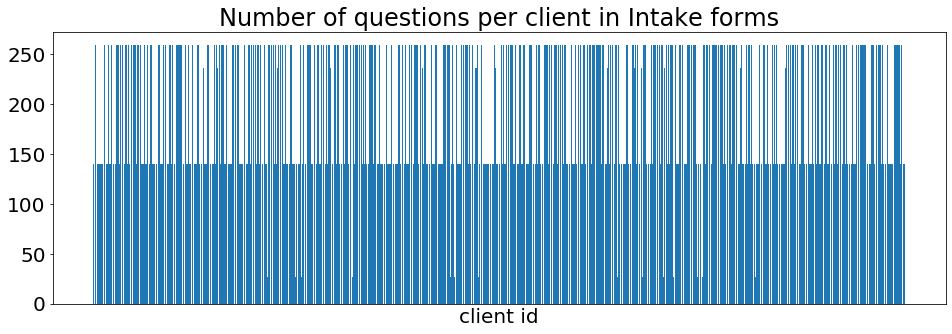

In [29]:
visualizeAnswerDataDf(answerDataDf)

In [30]:
showValueFrequencies(answerDataDf)

{259: 1014, 140: 881, 27: 46, 236: 42}

## Process tag Treatment (treatments.csv)

Uses Intake functions

In [18]:
QUERYTREATMENT = "./Treatment"
QUERYTREATMENTSTEP = ".//TreatmentStep"
OUTFILENAME = "treatments.csv.gz"
TITLESTRING = "Number of questions per client in treatment steps"
TREATMENTTITLE = "treatmentTitle"
PLOTFILENAME = "Treatment.png"

In [19]:
def getAnswerDataListTreatments(querySection=QUERYINTAKE):
    inFileNames = sorted(os.listdir(DATADIR))
    answerDataList = []
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIR+inFileName)
            for section in root.findall(querySection):
                for treatmentStep in section.findall(QUERYTREATMENTSTEP):
                    titleList = treatmentStep.findall("./"+TITLECAPS)
                    if not titleList is None and len(titleList) > 0 and not titleList[0].text is None:
                        treatmentTitle = titleList[0].text.strip()
                    else: treatmentTitle = ""
                    for question in treatmentStep.findall(QUERYQUESTION):
                        answerDict = {CLIENT:fileNameToId(inFileName),TREATMENTTITLE:treatmentTitle}
                        try:
                            answerDict[TITLE] = list(question.findall(QUERYTITLE))[0].text.strip()
                        except: pass
                        try:
                            answerDict[QUESTIONNUMBER] = list(question.findall(QUERYQUESTIONNUMBER))[0].text.strip()
                        except: pass
                        for answer in question.findall(QUERYANSWER):
                            answerDictCopy = dict(answerDict)
                            answerDictCopy[ANSWERID] = answer.attrib[ID]
                            try:
                                answerDictCopy[ANSWERTEXT] = list(answer.findall(QUERYANSWERTEXT))[0].text.strip()
                            except: pass
                            try:
                                answerDictCopy[ANSWERTITLE] = list(answer.findall(QUERYTITLE))[0].text.strip()
                            except: pass
                            answerDataList.append(answerDictCopy)
    return(answerDataList)

In [20]:
answerDataList = getAnswerDataListTreatments(querySection=QUERYTREATMENT)
answerTextFreqs = countAnswerTexts(answerDataList)
answerDataList = removeRareDataValues(answerDataList,answerTextFreqs)
answerDataDf = answerDataListToDf(answerDataList)
saveAnswerDataDf(answerDataDf,outFileName=OUTFILENAME)

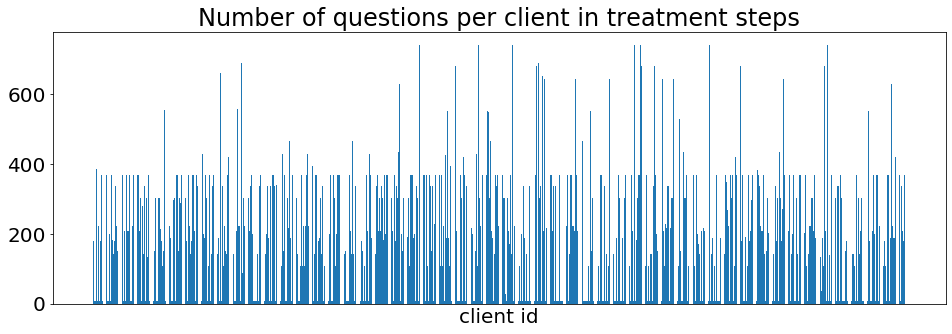

In [21]:
visualizeAnswerDataDf(answerDataDf,titleString=TITLESTRING,plotFileName=PLOTFILENAME)

In [22]:
showValueFrequencies(answerDataDf)

{8: 174,
 369: 141,
 9: 76,
 304: 56,
 337: 55,
 108: 45,
 142: 41,
 210: 39,
 224: 27,
 179: 26,
 189: 26,
 151: 20,
 199: 19,
 682: 9,
 645: 8,
 467: 7,
 742: 7,
 217: 6,
 422: 5,
 552: 5,
 182: 4,
 223: 3,
 429: 3,
 631: 3,
 434: 3,
 37: 3,
 135: 2,
 214: 2,
 297: 2,
 428: 2,
 689: 2,
 394: 2,
 488: 2,
 192: 2,
 228: 2,
 172: 2,
 654: 2,
 530: 2,
 203: 2,
 387: 1,
 279: 1,
 556: 1,
 290: 1,
 663: 1,
 559: 1,
 88: 1,
 340: 1,
 254: 1,
 165: 1,
 516: 1,
 427: 1,
 213: 1,
 550: 1,
 29: 1,
 335: 1,
 233: 1,
 154: 1,
 35: 1,
 205: 1,
 349: 1,
 268: 1,
 384: 1,
 272: 1,
 139: 1,
 144: 1}

In [23]:
inFileNames = sorted(os.listdir(DATADIR))
tags= {}
for inFileName in inFileNames:
    if re.search(FILEPATTERN,inFileName):
        root = readGzippedXmlFile(DATADIR+inFileName)
        for section in root.findall(QUERYTREATMENT):
            for tag in section.findall(".//*"):
                if not tag.tag in tags: tags[tag.tag] = 0
                tags[tag.tag] += 1
{tag:tags[tag] for tag in sorted(tags.keys(),key=lambda t:tags[t],reverse=True)}

{'answer': 179958,
 'answerText': 179958,
 'title': 108423,
 'question': 65265,
 'questionNumber': 62285,
 'Title': 12180,
 'TreatmentStep': 6821,
 'SubmissionDate': 6821,
 'ApprovalDate': 6821,
 'ApprovingCounselor': 6821,
 'FirstName': 6154,
 'LastName': 6154,
 'Questionnaire': 5375,
 'Type': 5375,
 'Content': 5375,
 'Status': 1983,
 'StartDate': 1983,
 'EndDate': 1983,
 'TreatmentSteps': 1983}

In [24]:
len(answerDataList)

179958

In [25]:
import sys

QUERYTREATMENTSTEP = "./TreatmentSteps/TreatmentStep"
QUERYTITLE = "./Title"
QUERYANSWER = ".//"+ANSWER

Most common treatment step order:

1. Voordelen, nadelen
2. Alcoholschrift bijhouden
3. Situaties analyseren
4. Meten en weten
5. Doel stellen
6. Gewoontes doorbreken
7. Anders denken
8. Anders doen
9. Beslissingen
10. Actieplan
11. Afsluiting
12. Na 3 maanden
13. Na half jaar
14. Na 9 maanden

In [26]:
inFileNames = sorted(os.listdir(DATADIR))
titles= {}
for inFileName in inFileNames:
    if re.search(FILEPATTERN,inFileName):
        root = readGzippedXmlFile(DATADIR+inFileName)
        questionCount = 0
        for section in root.findall(QUERYTREATMENT):
            questionCountAll = len(section.findall(QUERYANSWER))
            for treatmentStep in section.findall(QUERYTREATMENTSTEP):
                questionCount += len(treatmentStep.findall(QUERYANSWER))
                for title in treatmentStep.findall(QUERYTITLE):
                    titleText = cleanupText(title.text) # +" "+str(questionCountAll)+" "+str(questionCount)
                    if not titleText in titles: titles[titleText] = 0
                    titles[titleText] += 1
{titleText:titles[titleText] for titleText in sorted(titles.keys(),key=lambda t:titles[t],reverse=True)}

{'Voordelen, nadelen': 922,
 'Alcoholschrift bijhouden': 749,
 'Doel stellen': 689,
 'Situaties analyseren': 627,
 'Meten en weten': 574,
 'Gewoontes doorbreken': 497,
 'Anders denken': 472,
 'Anders doen': 442,
 'Afsluiting': 419,
 'Beslissingen': 418,
 'Actieplan': 396,
 'Na 3 maanden': 326,
 'Na half jaar': 264,
 'Na 9 maanden': 9,
 'Intake': 1}

## Process tag Diary (diaries.csv)

In [27]:
OUTFILENAME = "diaries.csv.gz"
QUERYDIARY = "./Diary"
QUERYDIARYENTRY = "./DiaryEntries/DiaryEntry"
UNKNOWN = "-"
SEP = "_"

def getAllTextFields(tag,prefix=""):
    textDict = {}
    for child in tag.findall("./*"):
        if prefix == "": key = child.tag
        else: key = prefix+SEP+child.tag
        if child.text != None:
            childText = cleanupText(child.text)
            if childText != "" and childText != "" and childText != UNKNOWN:
                textDict[key] = childText
        textDict.update(getAllTextFields(child,prefix=key))
    return(textDict)

def readDiaries():
    inFileNames = sorted(os.listdir(DATADIR))
    dataList = []
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIR+inFileName)
            for section in root.findall(QUERYDIARY):
                for diaryEntry in section.findall(QUERYDIARYENTRY):
                    clientDictData = {CLIENT:fileNameToId(inFileName)}
                    diaryEntryDict = getAllTextFields(diaryEntry)
                    clientDictData.update(diaryEntryDict)
                    dataList.append(clientDictData)
    return(dataList)

In [28]:
MINIMALDUPLICATEVALUES = 5
REMOVED = "REMOVED"

def countValues(listOfDict):
    countsDict = {}
    for i in range(0,len(listOfDict)):
        for dictKey in listOfDict[i].keys():
            if not dictKey in countsDict: countsDict[dictKey] = {}
            for token in word_tokenize(listOfDict[i][dictKey]):
                if not token in countsDict[dictKey]: countsDict[dictKey][token] = 0
                countsDict[dictKey][token] += 1
    return(countsDict)

def anonymize(listOfDict,countsDict,minimalDuplicateValues=MINIMALDUPLICATEVALUES):
    for i in range(0,len(listOfDict)):
        for dictKey in listOfDict[i].keys():
            tokenizedTextList = word_tokenize(listOfDict[i][dictKey])
            for j in range(0,len(tokenizedTextList)):
                if countsDict[dictKey][tokenizedTextList[j]] < minimalDuplicateValues and dictKey != CLIENT:
                    tokenizedTextList[j] = REMOVED
            listOfDict[i][dictKey] = " ".join(tokenizedTextList)
    return(listOfDict)

In [29]:
dataList = readDiaries()
countsDict = countValues(dataList)
dataListAnonymized = anonymize(dataList,countsDict)
saveAnswerDataDf(answerDataListToDf(dataListAnonymized),outFileName=OUTFILENAME)
print(f"Number of entries in list: {len(dataListAnonymized)}")

Number of entries in list: 122330


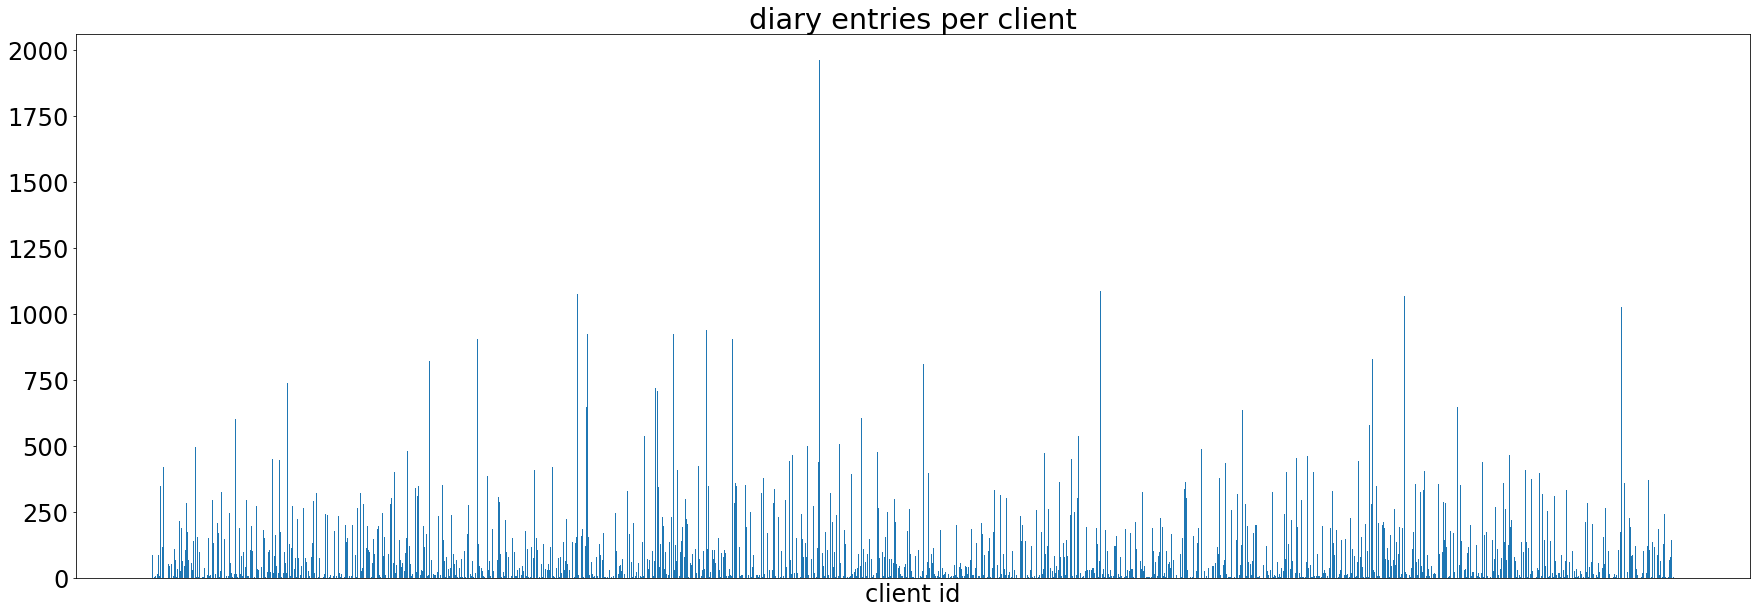

In [30]:
PLOTFILENAME = "Diary.png"

def showNumberOfDiaryEntriesPerClient():
    groups = pd.DataFrame(dataListAnonymized).groupby(CLIENT).groups
    x = groups.keys()
    y = [len(groups[client]) for client in x]

    font = {"size":24}
    matplotlib.rc("font",**font)
    plt.figure(figsize=(30,10))
    plt.bar(x,y)
    plt.title("diary entries per client")
    plt.xlabel("client id")
    plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
    plt.savefig(PLOTFILENAME)
    plt.show()
    
showNumberOfDiaryEntriesPerClient()

In [31]:
valueFrequencies = showValueFrequencies(pd.DataFrame(dataListAnonymized))
print(sum([valueFrequencies[k] for k in list(valueFrequencies.keys())]),
      sum([valueFrequencies[k] for k in list(valueFrequencies.keys()) if k < 10]),
      sum([valueFrequencies[k] for k in list(valueFrequencies.keys()) if k < 100]),
      sum([valueFrequencies[k] for k in list(valueFrequencies.keys()) if k >= 100]))

1245 398 854 391


* 1983-1245 = 738 empty diaries
* 398 more diaries with fewer than 10 entries
* 854-398 = 456 more diaries with fewer than 100 entries
* 391 diaries with 100 entries or more (max 1961)

In [32]:
QUERYDIARY = "./Diary"

def showDiaryTextFieldFrequencies():
    inFileNames = sorted(os.listdir(DATADIR))
    tags= {}
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIR+inFileName)
            for section in root.findall(QUERYDIARY):
                for tag in section.findall(".//*"):
                    if not tag.tag in tags: tags[tag.tag] = 0
                    tags[tag.tag] += 1
    return(tags)

tags = showDiaryTextFieldFrequencies()
{tag:tags[tag] for tag in sorted(tags.keys(),key=lambda t:tags[t],reverse=True)}

{'DiaryEntry': 122330,
 'Date': 122330,
 'Time': 122330,
 'Urge': 122330,
 'StandardUnits': 122330,
 'Quantity': 82118,
 'MeasurementUnitName': 72465,
 'Snapshot': 18090,
 'Situation': 18090,
 'Location': 18090,
 'Companion': 18090,
 'Activity': 18090,
 'Occasion': 18090,
 'Thoughts': 18090,
 'Feeling': 18090,
 'Type': 18090,
 'Emotion': 18090,
 'Description': 18090,
 'Behavior': 18090,
 'BehaviorDetails': 18090,
 'DayTarget': 9653,
 'dayOfWeek': 9653,
 'DiaryEntries': 1983,
 'Targets': 1983,
 'DateLastOpenedByClient': 1983,
 'Target': 1379,
 'StartDate': 1379,
 'WeekTargetQuantity': 1379}

## Process tag Messages (emails.csv)

In [33]:
DATADIRANONYMIZED = "../usb/releases/20200320/"
DATESENT = "DateSent"
OUTFILENAME = "emails.csv.gz"
QUERYMESSAGES = "./Messages"
QUERYMESSAGESENTRY = "./Message"

def readMessages():
    inFileNames = sorted(os.listdir(DATADIRANONYMIZED))
    dataList = []
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIRANONYMIZED+inFileName)
            messages = []
            for section in root.findall(QUERYMESSAGES):
                for message in section.findall(QUERYMESSAGESENTRY):
                    clientDictData = {CLIENT:fileNameToId(inFileName)}
                    messagesDict = getAllTextFields(message)
                    clientDictData.update(messagesDict)
                    messages.append(clientDictData)
            dataList.extend([message for message in sorted(messages,key=lambda m:m[DATESENT])])
    return(dataList)

In [34]:
dataListAnonymized = readMessages()
saveAnswerDataDf(answerDataListToDf(dataListAnonymized),outFileName=OUTFILENAME)
print(f"Number of entries in list: {len(dataListAnonymized)}")

Number of entries in list: 45469


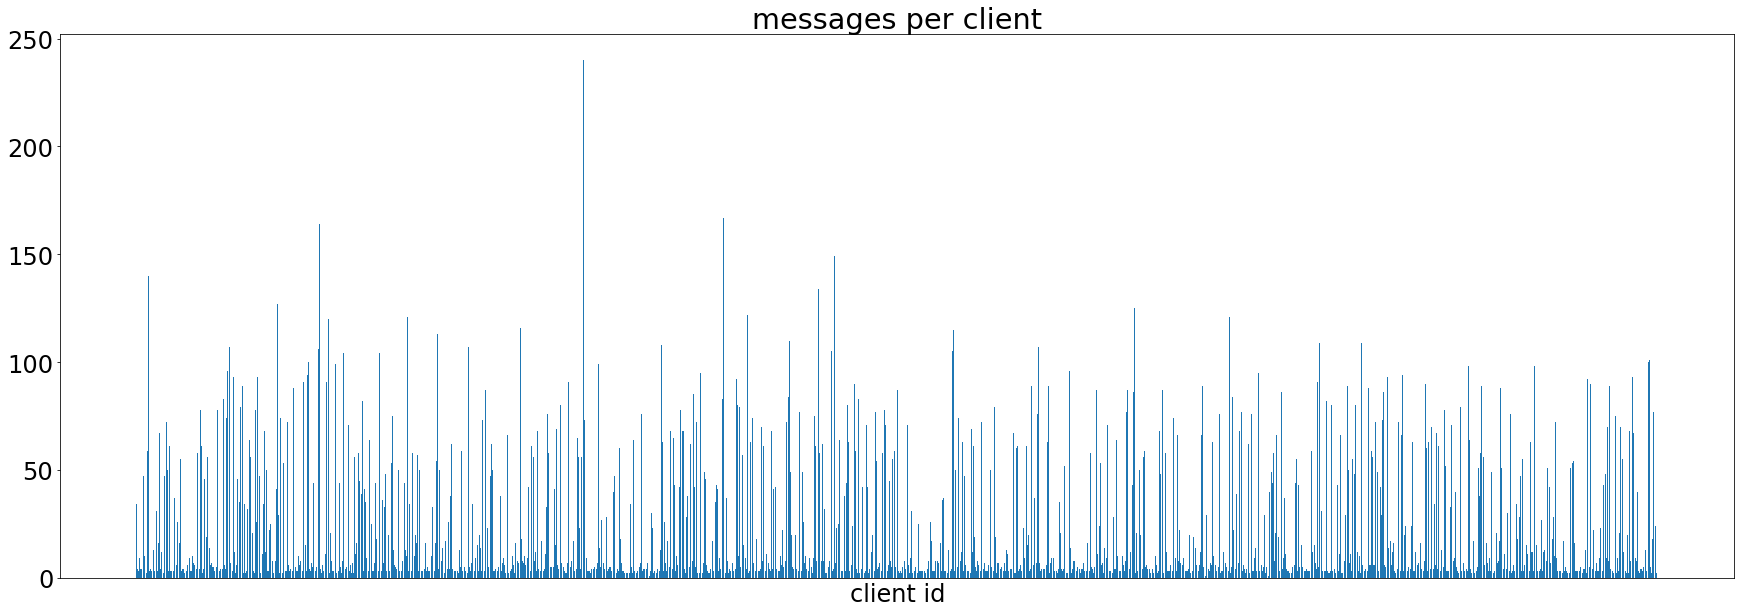

In [35]:
PLOTFILENAME = "Messages.png"

groups = pd.DataFrame(dataListAnonymized).groupby(CLIENT).groups
x = groups.keys()
y = [len(groups[client]) for client in x]

font = {"size":24}
matplotlib.rc("font",**font)
plt.figure(figsize=(30,10))
plt.bar(x,y)
plt.title("messages per client")
plt.xlabel("client id")
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.savefig(PLOTFILENAME)
plt.show()

In [36]:
valueFrequencies = showValueFrequencies(pd.DataFrame(dataListAnonymized))

In [37]:
print(sum([valueFrequencies[k] for k in list(valueFrequencies.keys())]),
      sum([valueFrequencies[k] for k in list(valueFrequencies.keys()) if k < 5]),
      sum([valueFrequencies[k] for k in list(valueFrequencies.keys()) if k < 50]),
      sum([valueFrequencies[k] for k in list(valueFrequencies.keys()) if k >= 50]),
      max([k for k in list(valueFrequencies.keys())]))

1982 789 1595 387 240


* 1983-1982 = 1 client with no mails
* 789 more clients with fewer than 5 mails
* 1595-789 = 806 more clients with fewer than 50 mails
* 387 clients with 50 mails or more (max 240)

In [38]:
QUERYMESSAGES = "./Messages"

def showMessageTextFieldFrequencies():
    inFileNames = sorted(os.listdir(DATADIRANONYMIZED))
    tags= {}
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIRANONYMIZED+inFileName)
            for section in root.findall(QUERYMESSAGES):
                for tag in section.findall(".//*"):
                    if not tag.tag in tags: tags[tag.tag] = 0
                    tags[tag.tag] += 1
    return(tags)

tags = showMessageTextFieldFrequencies()
{tag:tags[tag] for tag in sorted(tags.keys(),key=lambda t:tags[t],reverse=True)}

{'Message': 45469,
 'Sender': 45469,
 'Recipients': 45469,
 'DateSent': 45469,
 'Subject': 45469,
 'Body': 45469,
 'IsReplied': 45469,
 'Location': 45469,
 'TreatmentStep': 7017,
 'Attachments': 1894}